# 🔗 Notebook Integrado: ETL, Validação e Análises

# 🌦️ Projeto ETL: Dados Meteorológicos do Brasil
Transformando dados meteorológicos em informações usando Python e SQLite.

### 📦 Importação de Bibliotecas

Carregamento das bibliotecas necessárias para manipulação de dados, visualização e análise.

In [2]:
import pandas as pd
from sqlalchemy import create_engine

DB_URL = "sqlite:///weather.db" 

### 📥 Carregamento de Dados

Importa os dados meteorológicos de arquivos CSV ou banco de dados SQLite para análise.

In [11]:
weather = pd.read_csv("hourly-weather-southeast.csv")
weather.head()

,station,datetime,temperature,humidity,pressure,wind_speed
0,Station_C,2023-01-01 00:00:00,25.18,61.81,1003.76,12.79
1,Station_C,2023-01-01 01:00:00,25.97,45.98,1021.27,12.64
2,Station_A,2023-01-01 02:00:00,22.22,72.53,1022.68,6.98
3,Station_B,2023-01-01 03:00:00,24.58,67.78,1015.40,13.87
4,Station_B,2023-01-01 04:00:00,23.66,33.35,1022.86,0.13


### ⚙️ Processamento de Dados

- Converte o tipo de dados da coluna 'datetime' para o tipo de dados 'datetime64';
- Copia o último valor válido anterior para os campos vazios seguintes na mesma coluna;
- ! Isso é útil para sensores que falharam momentaneamente, mantendo a continuidade dos dados.

In [14]:
weather["datetime"] = pd.to_datetime(weather["datetime"])
weather.fillna(method='ffill', inplace=True)

/var/folders/st/x4wswrr96fj_sm0kkm09t9zc0000gn/T/ipykernel_79812/1319116219.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather.fillna(method='ffill', inplace=True)


### 🔁 Agregação de Dados

Agrupa os dados por estação e data, calculando médias para variáveis meteorológicas.

In [15]:
weather["date"] = weather["datetime"].dt.date
weather_daily = weather.groupby(["station", "date"]).agg({
    "temperature": "mean",
    "humidity": "mean",
    "pressure": "mean",
    "wind_speed": "mean"
}).reset_index()
weather_daily.head()

,station,date,temperature,humidity,pressure,wind_speed
0,Station_A,2023-01-01,27.370000,60.372857,1006.855714,9.195714
1,Station_A,2023-01-02,25.932857,77.102857,1009.854286,6.210000
2,Station_A,2023-01-03,23.276667,66.521111,1010.222222,7.148889
3,Station_A,2023-01-04,26.956667,73.891667,1014.751667,7.623333
4,Station_A,2023-01-05,25.605556,56.704444,1004.394444,6.336667


### 💾 Exportação para Banco de Dados

Grava os dados processados no banco SQLite nas tabelas especificadas.

In [6]:
db_engine = create_engine(DB_URL)

weather.to_sql("weather_hourly", db_engine, if_exists="replace", index=False)
weather_daily.to_sql("weather_daily", db_engine, if_exists="replace", index=False)
print("Carga completa!")

Carga completa!


## ✅ Validação de Dados

# 🧪 Validação de Dados e Boas Práticas - Meteorologia

Este notebook valida a integridade e consistência dos dados após a ingestão, além de seguir práticas modernas com Pandas e SQLAlchemy.

- Verificações de qualidade
- Testes unitários simples
- Sintaxe clara e eficiente
- Comentários explicativos


### 📦 Importação de Bibliotecas

Carregamento das bibliotecas necessárias para manipulação de dados, visualização e análise.

In [7]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

DB_URL = "sqlite:///weather.db"
engine = create_engine(DB_URL)

# Carregar dados
hourly = pd.read_sql("SELECT * FROM weather_hourly", engine)
daily = pd.read_sql("SELECT * FROM weather_daily", engine)


### ✅ Testes de Validação

Verifica a consistência dos dados com testes simples usando assertivas.

In [8]:
assert 'datetime' in hourly.columns, "Coluna datetime ausente"
assert pd.api.types.is_numeric_dtype(hourly['temperature']), "Temperatura deve ser numérica"
assert len(hourly) > 0, "Dataset não pode estar vazio"


### ✅ Testes de Validação

Verifica a consistência dos dados com testes simples usando assertivas.

In [9]:
duplicated = hourly.duplicated().sum()
print(f"Registros duplicados: {duplicated}")
assert duplicated == 0, "Existem duplicatas no dataset"


Registros duplicados: 0


### ✅ Testes de Validação

Verifica a consistência dos dados com testes simples usando assertivas.

In [10]:
assert hourly['humidity'].between(0, 100).all(), "Umidade fora do intervalo"
assert hourly['temperature'].between(-50, 60).all(), "Temperatura fora do intervalo"


### 📦 Importação de Bibliotecas

Carregamento das bibliotecas necessárias para manipulação de dados, visualização e análise.

In [11]:
from datetime import datetime

hourly['date'] = pd.to_datetime(hourly['datetime']).dt.date
grouped = hourly.groupby(['station', 'date'])['temperature'].mean().reset_index()
merged = pd.merge(grouped, daily[['station', 'date', 'temperature']], on=['station', 'date'], how='inner', suffixes=('_hour', '_daily'))
diff = (merged['temperature_hour'] - merged['temperature_daily']).abs()
assert (diff < 1e-3).all(), "Inconsistência nas médias de temperatura"


## 📊 Análises

# 🌦️ Dados Meteorológicos - Região Sudeste

### 📦 Importação de Bibliotecas

Carregamento das bibliotecas necessárias para manipulação de dados, visualização e análise.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import plotly.express as px

sns.set(style="whitegrid")
DB_URL = "sqlite:///weather.db"
engine = create_engine(DB_URL)

weather = pd.read_sql("SELECT * FROM weather_hourly", engine)
weather["datetime"] = pd.to_datetime(weather["datetime"])
weather["hour"] = weather["datetime"].dt.hour
weather["month"] = weather["datetime"].dt.month
weather["weekday"] = weather["datetime"].dt.day_name()


### ⚙️ Processamento de Dados

Etapas intermediárias de transformação, tratamento de valores nulos ou ajustes.

In [13]:
weather.info()
weather.describe()
weather.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      1000 non-null   object        
 1   datetime     1000 non-null   datetime64[ns]
 2   temperature  1000 non-null   float64       
 3   humidity     1000 non-null   float64       
 4   pressure     1000 non-null   float64       
 5   wind_speed   1000 non-null   float64       
 6   date         1000 non-null   object        
 7   hour         1000 non-null   int32         
 8   month        1000 non-null   int32         
 9   weekday      1000 non-null   object        
dtypes: datetime64[ns](1), float64(4), int32(2), object(3)
memory usage: 70.4+ KB


station        0
datetime       0
temperature    0
humidity       0
pressure       0
wind_speed     0
date           0
hour           0
month          0
weekday        0
dtype: int64

### ⚙️ Processamento de Dados

Etapas intermediárias de transformação, tratamento de valores nulos ou ajustes.

In [14]:
weather["feels_like"] = weather["temperature"] - ((100 - weather["humidity"]) / 5)

# Categorias de temperatura
def temp_category(temp):
    if temp < 18: return "Frio"
    elif temp < 28: return "Agradável"
    else: return "Quente"

weather["temp_category"] = weather["temperature"].apply(temp_category)

### 📊 Gráfico 1: Visualização

### 📊 Visualização de Dados

Gera gráficos para explorar relações entre variáveis meteorológicas.

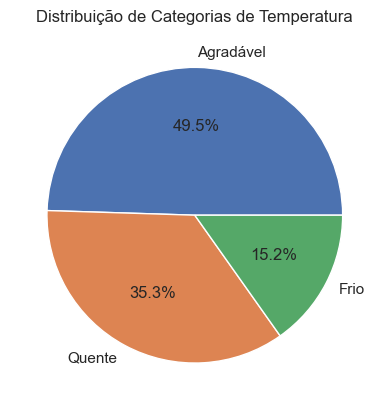

In [15]:
weather['temp_category'].value_counts().plot.pie(autopct='%1.1f%%', title='Distribuição de Categorias de Temperatura')
plt.ylabel('')
plt.show()

### 📊 Gráfico 2: Visualização

### 📊 Visualização de Dados

Gera gráficos para explorar relações entre variáveis meteorológicas.

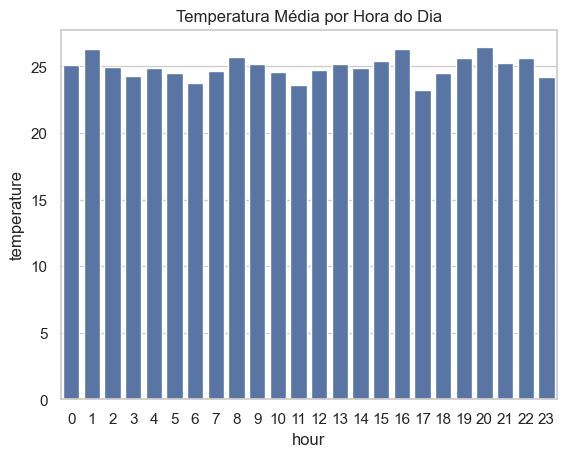

In [16]:
sns.barplot(x='hour', y='temperature', data=weather, errorbar=None)
plt.title('Temperatura Média por Hora do Dia')
plt.show()

### 📊 Gráfico 3: Visualização

### 📊 Visualização de Dados

Gera gráficos para explorar relações entre variáveis meteorológicas.

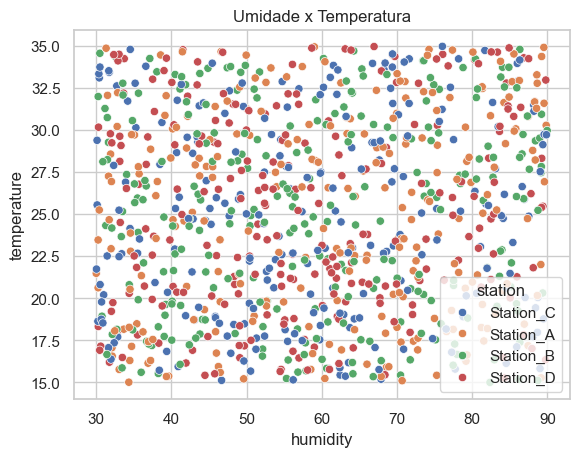

In [17]:
sns.scatterplot(x='humidity', y='temperature', data=weather, hue='station')
plt.title('Umidade x Temperatura')
plt.show()

### 📊 Gráfico 4: Visualização

### 🔁 Agregação de Dados

Agrupa os dados por estação e data, calculando médias para variáveis meteorológicas.

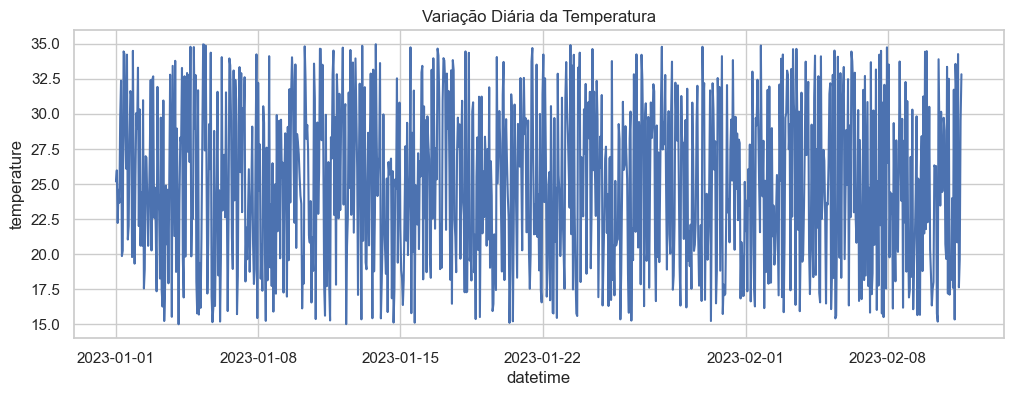

In [18]:
daily_avg = weather.groupby(['datetime']).agg({'temperature':'mean'}).reset_index()
plt.figure(figsize=(12,4))
sns.lineplot(data=daily_avg, x='datetime', y='temperature')
plt.title('Variação Diária da Temperatura')
plt.show()

### 🧪 Testes Automatizados
Verificação rápida de integridade dos dados.

In [19]:
# Verificar se tabelas essenciais existem no banco
from sqlalchemy import inspect
inspector = inspect(engine)
tables = inspector.get_table_names()
assert "weather_hourly" in tables, "Tabela 'weather_hourly' ausente"
assert "weather_daily" in tables, "Tabela 'weather_daily' ausente"
print("✅ Tabelas essenciais presentes.")

# Verificar colunas críticas
df_hourly = pd.read_sql("SELECT * FROM weather_hourly LIMIT 10", engine)
expected_cols = {"station", "datetime", "temperature", "humidity", "pressure", "wind_speed"}
assert expected_cols.issubset(df_hourly.columns), "Colunas ausentes em weather_hourly"
print("✅ Colunas essenciais verificadas.")

✅ Tabelas essenciais presentes.
✅ Colunas essenciais verificadas.
